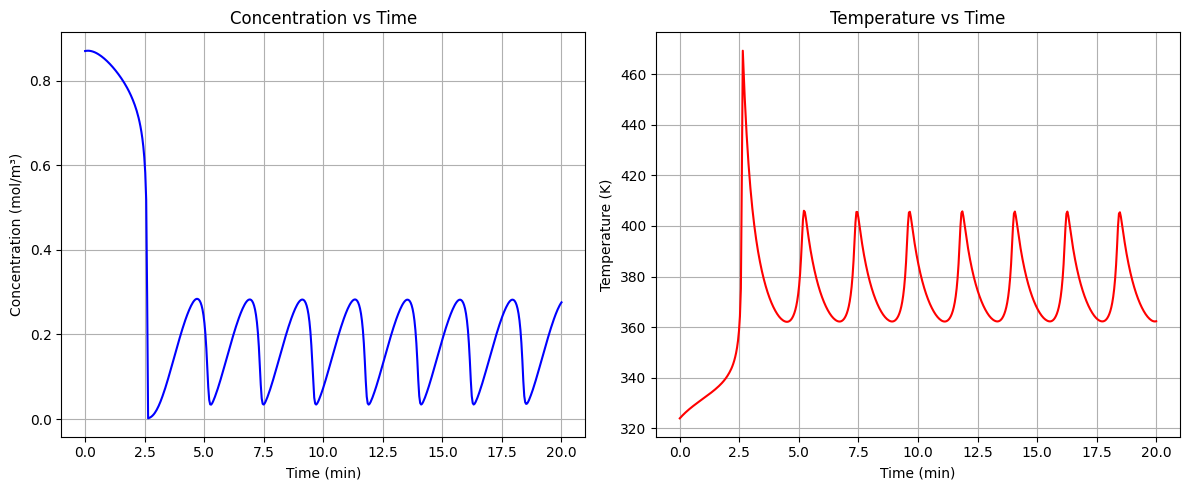

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q   = 100.0     # Flowrate [L/min]
cAf = 1.0       # Inlet feed concentration [mol/L]

Tf  = 350.0     # Inlet feed temperature [K]
Tc  = 305.0     # Coolant temperature [K]
cA0 = 0.87       # Initial concentration [mol/L]
T_0  = 324   # Initial temperature [K]

# Initial Conditions
y0 = [cA0, T_0]

ODE_SOLVER = 'LSODA'  # ODE solver method

# Rate constant as a function of temperature
def k(T):
    return k0 * np.exp(-Ea / (R * T))

# CSTR model
def cstr_model(t, y):
    cA, T = y
    dcAdt = (q/V)*(cAf - cA) - k(T)*cA
    dTdt = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcAdt, dTdt]

# Time span and evaluation points
t_span = (0, 20)  # simulate for 1 minute due to fast dynamics
t_eval = np.linspace(*t_span, 500)

# Solve the ODEs
solution = solve_ivp(cstr_model, t_span, y0, t_eval=t_eval)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(solution.t, solution.y[0], label='$C_A$', color='blue')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration vs Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(solution.t, solution.y[1], label='T', color='red')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs Time')
plt.grid(True)

plt.tight_layout()
plt.show()


### PID

In [17]:
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, measured_value, dt):
        error = self.setpoint - measured_value
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0

        output = (
            self.Kp * error +
            self.Ki * self.integral +
            self.Kd * derivative
        )

        self.prev_error = error
        return output


In [18]:
def system_dynamics(t, y, p):
    cA, T = y
    dcAdt = (q/V)*(cAf - cA) - k(T)*cA
    dTdt = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*cA - (UA/V/rho/Cp)*(T - p)  
    return [dcAdt, dTdt]

  0%|          | 0/200 [00:00<?, ?it/s]/home/kostasme/.kostas/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `r_tol`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
100%|██████████| 200/200 [00:00<00:00, 9305.79it/s]


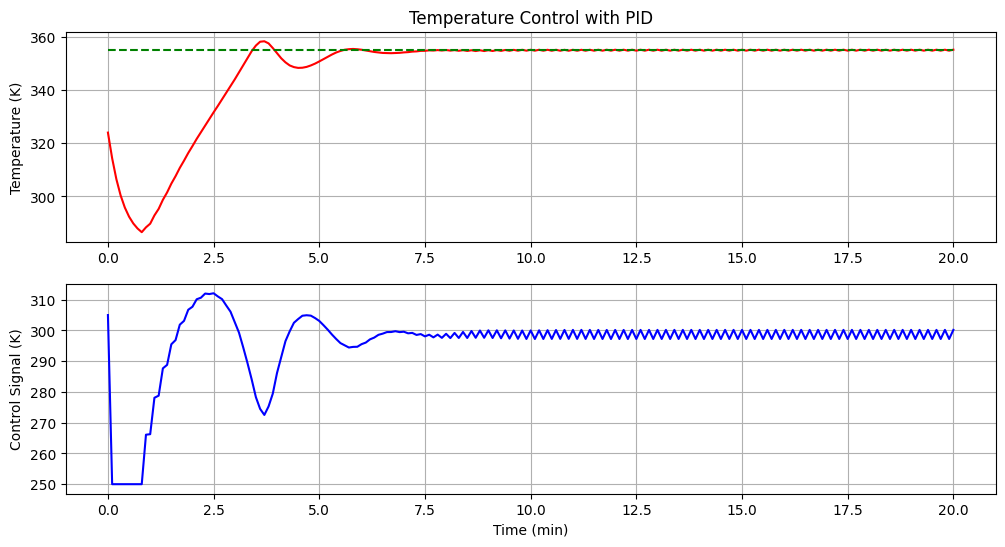

In [19]:
T_START, T_END = 0, 20
dt = 0.1
time = np.arange(T_START, T_END + dt, dt)

setpoint = 355 # K

pid = PID(Kp=2.3, Ki=2.1, Kd=0.3, setpoint=setpoint)

concentration = cA0
temperature = T_0
C_hist = [cA0]
T_hist = [T_0]
u_hist = [Tc]
t_hist = [time[0]]

for i in tqdm(range(1, len(time))):
    t = time[i-1]
    cv = pid.update(temperature, dt)
    cv = np.clip(cv, 250, 350)
    sol = solve_ivp(system_dynamics, [t,t+dt], [concentration,temperature], args=(cv,), t_eval=[t+dt], method='LSODA', r_tol=1e-12, atol=1e-12)
    # Update concentration and temperature
    concentration, temperature = sol.y[:, -1]
    C_hist.append(concentration)
    T_hist.append(temperature)
    u_hist.append(cv)
    t_hist.append(t+dt)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(t_hist, T_hist, label='T', color='red')
plt.plot(t_hist, [pid.setpoint]*len(t_hist), label='Setpoint', color='green', linestyle='--')
plt.ylabel('Temperature (K)')
plt.title('Temperature Control with PID')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(t_hist, u_hist, label='Control Signal', color='blue')
plt.xlabel('Time (min)')
plt.ylabel('Control Signal (K)')
plt.grid(True)
plt.show()

IMC

MPC

In [119]:
# MPC parameters
dt = 0.1
TIME_RANGE = T_END - T_START # Time step
L = int(TIME_RANGE / dt)         # Simulation steps
N_p = 10                      # Prediction horizon
Q = 20                        # Weight for tracking
R = 10                        # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'SLSQP'    # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

p_MIN = 250.0
p_MAX = 350.0
BOUNDS = [(p_MIN, p_MAX) for _ in range(N_p)]  # Bounds for the control inputs

In [120]:
# ---- ODE wrapper ----
def solve_ode(ode, t_span, y0, method, t_eval, args):
    return solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval)

# ---- Cost function ----
def cost_function(p_opt: list, conc: float, temp: float) -> float:
    J = 0.0
    for k in range(N_p):
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[conc, temp], \
            method=ODE_SOLVER, t_eval=[dt], args=(p_opt[k],))
        conc_next = sol.y[0][-1]
        temp_next = sol.y[1][-1]
        J += Q * (setpoint - temp_next)**2
        if k > 0:
            J += R * (p_opt[k] - p_opt[k-1])**2
        conc = conc_next
        temp = temp_next
    return J

In [121]:
T_vals = np.zeros(L)
C_vals = np.zeros(L)
p_vals = np.zeros(L)

T_vals[0] = T_0
C_vals[0] = cA0
p_vals[0] = Tc

for i in tqdm(range(L-1)):
    u0 = np.ones(N_p) * p_vals[i]
    res = minimize(cost_function, u0, args=(C_vals[i], T_vals[i]), \
        bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    p_new = res.x[0]
    p_vals[i+1] = p_new
    sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[C_vals[i], T_vals[i]], \
        method=ODE_SOLVER, t_eval=[dt], args=(p_new,))
    C_vals[i+1] = sol.y[0][-1]
    T_vals[i+1] = sol.y[1][-1]

100%|██████████| 199/199 [00:16<00:00, 11.77it/s]


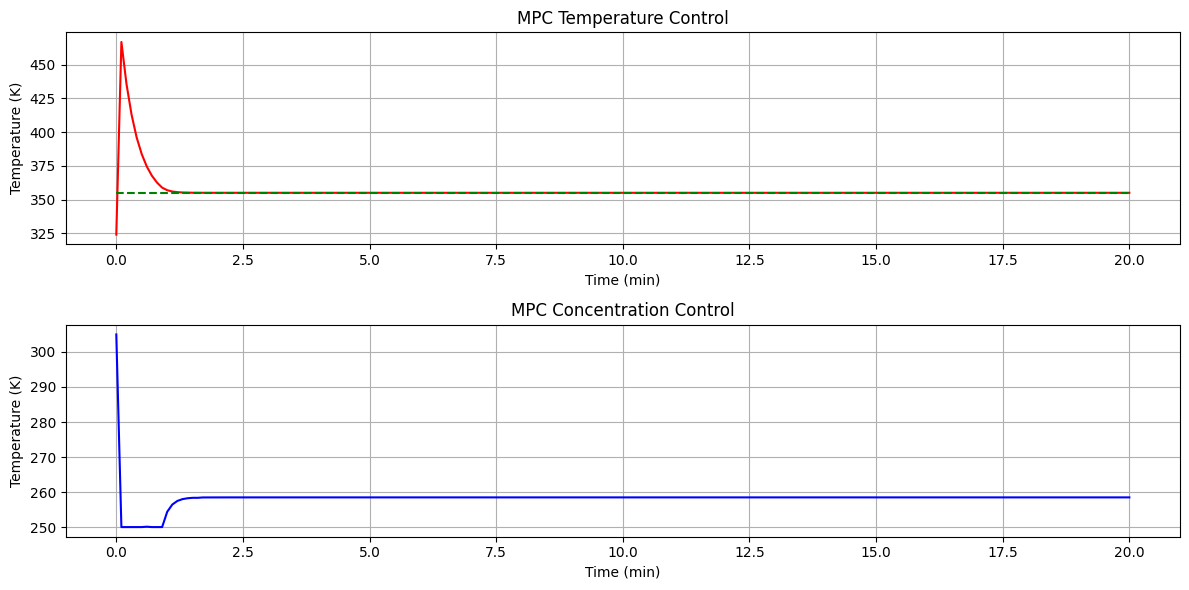

In [122]:
# Plotting
time_mpc = np.linspace(T_START, T_END, L)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_mpc, T_vals, label='T', color='red')
plt.plot(time_mpc, [setpoint]*len(time_mpc), label='Setpoint', color='green', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')
plt.title('MPC Temperature Control')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(time_mpc, p_vals, label='$C_A$', color='blue')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (K)')
plt.title('MPC Concentration Control')
plt.grid(True)
plt.tight_layout()
plt.show()

__Optional__: Re-simulation

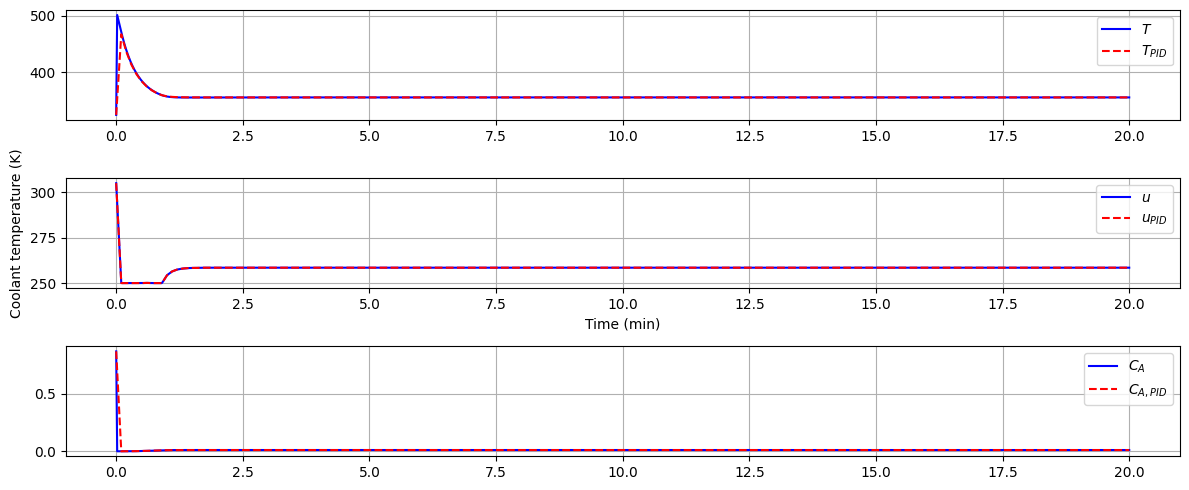

In [130]:
from scipy.interpolate import interp1d

p_func = interp1d(time_mpc, p_vals, kind='linear', fill_value='extrapolate')

t_eval = np.linspace(T_START, T_END, 1000)
t_span = (T_START, T_END)
y0 = [C_hist[0], T_hist[0]]
eval_sol = solve_ivp(
    lambda t, y: system_dynamics(t, y, p_func(t)), t_span, y0, t_eval=t_eval, method='LSODA', r_tol=1e-6, atol=1e-12
)


# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(3, 1, 1)
plt.plot(eval_sol.t, eval_sol.y[1], label='$T$', color='blue')
plt.plot(time_mpc, T_vals, label='$T_{PID}$', color='red', linestyle='--')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(eval_sol.t, p_func(eval_sol.t), label='$u$', color='blue')
plt.plot(time_mpc, p_vals, label='$u_{PID}$', color='red', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Time (min)')
plt.ylabel('Coolant temperature (K)')

plt.subplot(3, 1, 3)
plt.plot(eval_sol.t, eval_sol.y[0], label='$C_A$', color='blue')
plt.plot(time_mpc, C_vals, label='$C_{A,PID}$', color='red', linestyle='--')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
